In [5]:
# ==============================
# BOX 1: IMPORTS
# ==============================

import numpy as np
import pandas as pd
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score  # optional, for debugging


In [6]:
# ==============================
# BOX 2: HELPERS & GLOBALS
# ==============================

# ----- Parsers -----
def parse_cuisine_rank(val):
    if isinstance(val, dict):
        return val
    if not isinstance(val, str):
        return {}
    s = val.replace("np.str_(", "").replace(")", "")
    try:
        return literal_eval(s)
    except:
        return {}

def parse_offer_set(val):
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        try:
            return literal_eval(val)
        except:
            return []
    return []

# ----- Feature Engineering -----
def get_ml_features(user_row, rest_row):
    """
    Same features as your original RF pipeline.
    """
    # 1. Cuisine Match
    ranks = user_row['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest_row['cuisine'], C)
    x_cuisine = (C - r_rank) / (C - 1) if C > 1 else 0.0

    # 2. Price Gap (Price - Tolerance)
    x_price_gap = float(rest_row['price_level']) - float(user_row['price_tolerance'])

    # 3. Rating
    x_rating = (float(rest_row['rating_5star']) - 3.0) / 2.0

    # 4. ETA
    dx = user_row['x'] - rest_row['x']
    dy = user_row['y'] - rest_row['y']
    x_eta = np.sqrt(dx**2 + dy**2) / 10.0

    # 5. Raw Price
    x_price_raw = float(rest_row['price_level'])

    return [x_cuisine, x_price_gap, x_rating, x_eta, x_price_raw]

feature_names = ["CuisineMatch", "PriceGap", "Rating", "ETA", "PriceRaw"]

# ----- Oracle Utility -----
PROFILES = {
    1: [0.0, 2.5, 0.7, 0.8, 0.7],  2: [0.0, 1.0, 2.2, 0.4, 0.6],
    3: [0.0, 1.0, 0.8, 2.8, 0.5],  4: [0.0, 0.9, 0.7, 0.7, 2.5],
    5: [0.0, 1.3, 1.0, 2.1, 0.7],  6: [0.0, 1.5, 1.5, 1.5, 1.5],
    7: [0.0, 1.8, 0.3, 1.2, 0.9],  8: [0.0, 1.2, 1.9, 0.9, 0.3],
    9: [0.0, 1.0, 1.0, 0.8, 1.8], 10:[0.0, 1.2, 0.8, 2.0, 1.7]
}

def get_gt_utility(user, rest):
    ranks = user['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest['cuisine'], C)
    cm = (C - r_rank) / (C - 1) if C > 1 else 0.0

    diff = user['price_tolerance'] - rest['price_level']
    pp = abs(diff) * (0.5 if diff >= 0 else 1.5)

    rn = (rest['rating_5star'] - 3.0) / 2.0
    dx, dy = user['x'] - rest['x'], user['y'] - rest['y']
    eta = np.sqrt(dx**2 + dy**2) / 10.0

    beta = PROFILES[user['profile']]
    return beta[0] + (beta[1]*cm) - (beta[2]*pp) + (beta[3]*rn) - (beta[4]*eta)

def evaluate_ground_truth(user, assortment_ids, restaurants_df):
    best_util = -np.inf
    revenue = 0.0
    chosen_id = None

    for rid in assortment_ids:
        rest = restaurants_df[restaurants_df['restaurant_id'] == rid].iloc[0]
        u_true = get_gt_utility(user, rest)
        if u_true > best_util:
            best_util = u_true
            revenue = rest['price_level']
            chosen_id = rid

    return revenue, chosen_id

# ----- Assortment from a trained model -----
def get_ml_optimal_assortment(user, clf_model, restaurants_df, K=5):
    user_features_list = []
    prices = []
    ids = []

    for _, rest in restaurants_df.iterrows():
        feats = get_ml_features(user, rest)
        user_features_list.append(feats)
        prices.append(rest['price_level'])
        ids.append(rest['restaurant_id'])

    X_score = pd.DataFrame(user_features_list, columns=feature_names)
    probs = clf_model.predict_proba(X_score)[:, 1]
    scores = probs * np.array(prices)

    top_k_indices = np.argsort(-scores)[:K]
    return [ids[i] for i in top_k_indices]


In [ ]:
# ==============================
# BOX 3: MAIN PIPELINE
#   - RF baseline + tuned price-based penalties
# ==============================

print("--- 1. Loading Data ---")

tx_df = pd.read_csv("data/groundtruth_transaction_data.csv")
restaurants = pd.read_csv("data/berkeley_real_restaurants_100.csv")

# Extract Users (including profile_name)
user_cols = ['user_id', 'x', 'y', 'profile', 'profile_name', 'price_tolerance', 'cuisine_rank']
users = tx_df[user_cols].drop_duplicates(subset='user_id').reset_index(drop=True)

# Parse complex columns
users['cuisine_rank_dict'] = users['cuisine_rank'].apply(parse_cuisine_rank)
tx_df['offer_set_ids'] = tx_df['offer_set_ids'].apply(parse_offer_set)

print(f"Loaded {len(restaurants)} restaurants.")
print(f"Loaded {len(tx_df)} transactions.")

# ==============================
# 2. BUILD TRAINING DATA (with price attached per row)
# ==============================
print("\n--- 2. Preparing ML Training Data (with PriceBase) ---")

ml_rows = []

# Same sampling strategy as your original code
train_tx = tx_df.sample(n=min(2000, len(tx_df)), random_state=42)

for _, row in train_tx.iterrows():
    u_id = row['user_id']
    user = users[users['user_id'] == u_id].iloc[0]
    offer_ids = row['offer_set_ids']
    chosen_id = row['chosen_id']

    for rid in offer_ids:
        rest = restaurants[restaurants['restaurant_id'] == rid].iloc[0]
        feats = get_ml_features(user, rest)
        label = 1 if rid == chosen_id else 0
        price_level = float(rest['price_level'])

        # features + label + base price used for penalties
        ml_rows.append(feats + [label, price_level])

train_df = pd.DataFrame(ml_rows, columns=feature_names + ["Label", "PriceBase"])

X_train = train_df[feature_names]
y_train = train_df["Label"]
price_base = train_df["PriceBase"].values

print(f"Training Data: {len(train_df)} rows.")
print(f"Class Balance: {y_train.mean():.1%} positive (chosen).")
print(f"Avg Base Price: {price_base.mean():.3f}")

# ==============================
# 3. BASELINE RF (NO PRICE PENALTY)
# ==============================
print("\n--- 3. Training BASELINE Random Forest (no penalty) ---")

baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,           # same as your original
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

baseline_rf.fit(X_train, y_train)

# Optional: show baseline feature importances
base_importances = dict(zip(feature_names, baseline_rf.feature_importances_))
print("Baseline Feature Importances:")
for f, imp in sorted(base_importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {f:12s}: {imp:.4f}")

# ==============================
# 4. DEFINE TUNING USER SET & BASELINE REVENUE
# ==============================
print("\n--- 4. Evaluating BASELINE RF on tuning users ---")

rest_name_map = restaurants.set_index('restaurant_id')['name'].to_dict()
tune_users = users.head(200)   # same N=200 as before

def compute_avg_revenue_for_model(clf_model, users_df, restaurants_df, K=5):
    revenues = []
    for _, user in users_df.iterrows():
        rec_ids = get_ml_optimal_assortment(user, clf_model, restaurants_df, K=K)
        rev, _ = evaluate_ground_truth(user, rec_ids, restaurants_df)
        revenues.append(rev)
    return np.mean(revenues), np.sum(revenues)

baseline_avg_rev, baseline_total_rev = compute_avg_revenue_for_model(
    baseline_rf, tune_users, restaurants, K=5
)

print(f"Baseline Total Revenue (tuning users): ${baseline_total_rev:.2f}")
print(f"Baseline Avg Rev / User (tuning):      ${baseline_avg_rev:.2f}")

best_model = baseline_rf
best_penalty = 0.0
best_avg_rev = baseline_avg_rev
best_total_rev = baseline_total_rev

# ==============================
# 5. TRAIN PENALIZED RF MODELS & PICK BEST BY REVENUE
# ==============================
print("\n--- 5. Training PENALIZED Random Forests (price-based) ---")

# We'll keep *the same RF archi*
penalty_grid = np.linspace(0.1, 2, 20)  # you can tweak this

for penalty_exp in penalty_grid:
    print(f"\n=== Trying penalty exponent: {penalty_exp} ===")

    # Sample weights: w_i = PriceBase_i ** penalty_exp (normalized so mean ~ 1)
    sw_raw = price_base ** penalty_exp
    sw = sw_raw * (price_base.mean() / sw_raw.mean())

    rf_penalized = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    rf_penalized.fit(X_train, y_train, sample_weight=sw)

    avg_rev, total_rev = compute_avg_revenue_for_model(
        rf_penalized, tune_users, restaurants, K=5
    )

    print(f"  Avg Rev / User (tuning): ${avg_rev:.2f} (Total: ${total_rev:.2f})")

    if avg_rev > best_avg_rev:
        print("  -> New best model found based on revenue!")
        best_model = rf_penalized
        best_penalty = penalty_exp
        best_avg_rev = avg_rev
        best_total_rev = total_rev

print("\n==============================")
print("MODEL SELECTION SUMMARY")
print("==============================")
print(f"Baseline Avg Rev / User:       ${baseline_avg_rev:.2f}")
print(f"Best Avg Rev / User (tuning):  ${best_avg_rev:.2f}")
print(f"Best penalty exponent:         {best_penalty}")
print("==============================")

rf_model = best_model  # this is what you use downstream

# ==============================
# 6. FINAL REPORT ON THE SAME 200 USERS
# (you can optionally use a different eval set)
# ==============================
print("\n--- 6. Final ML Pipeline Evaluation (N=200 tuning users) ---")

results = []
for _, user in tune_users.iterrows():
    rec_ids = get_ml_optimal_assortment(user, rf_model, restaurants, K=5)
    rec_names = [rest_name_map[rid] for rid in rec_ids]
    rev, chosen_id = evaluate_ground_truth(user, rec_ids, restaurants)

    results.append({
        "User ID": user['user_id'],
        "Profile": user['profile_name'],
        "Rec IDs": rec_ids,
        "Rec Names": rec_names,
        "Chosen ID": chosen_id,
        "Chosen Name": rest_name_map.get(chosen_id, "None"),
        "Revenue": rev
    })

ml_report_df = pd.DataFrame(results)

print("\n" + "="*40)
print("ML PIPELINE RESULTS (RF, best price penalty by revenue)")
print("="*40)
print(f"Total Revenue (tuning users):   ${ml_report_df['Revenue'].sum():.2f}")
print(f"Avg Rev / User (tuning users):  ${ml_report_df['Revenue'].mean():.2f}")
print("="*40)

pd.set_option('display.max_colwidth', None)
display(ml_report_df.head(5))

--- 1. Loading Data ---
Loaded 100 restaurants.
Loaded 200 transactions.

--- 2. Preparing ML Training Data (with PriceBase) ---
Training Data: 1000 rows.
Class Balance: 20.0% positive (chosen).
Avg Base Price: 1.622

--- 3. Training BASELINE Random Forest (no penalty) ---
Baseline Feature Importances:
  CuisineMatch: 0.3824
  PriceGap    : 0.2196
  ETA         : 0.2189
  Rating      : 0.1422
  PriceRaw    : 0.0368

--- 4. Evaluating BASELINE RF on tuning users ---
Baseline Total Revenue (tuning users): $399.00
Baseline Avg Rev / User (tuning):      $2.00

--- 5. Training PENALIZED Random Forests (price-based) ---

=== Trying penalty exponent: 0.1 ===
  Avg Rev / User (tuning): $1.98 (Total: $395.00)

=== Trying penalty exponent: 0.2 ===
  Avg Rev / User (tuning): $2.02 (Total: $403.00)
  -> New best model found based on revenue!

=== Trying penalty exponent: 0.3 ===
  Avg Rev / User (tuning): $2.00 (Total: $401.00)

=== Trying penalty exponent: 0.4 ===
  Avg Rev / User (tuning): $2.00

,User ID,Profile,Rec IDs,Rec Names,Chosen ID,Chosen Name,Revenue
0,0,Budget Shopper,"[71, 7, 64, 52, 9]","[Farmhouse Kitchen Thai Cuisine, Iyasare, Heroic Italian, Daryoush, Skates On The Bay]",71,Farmhouse Kitchen Thai Cuisine,3
1,1,Budget Shopper,"[66, 2, 64, 33, 56]","[Ike's Love & Sandwiches, Comal, Heroic Italian, Bangkok Noodles & Thai BBQ, East Bay Spice Company]",66,Ike's Love & Sandwiches,2
2,2,Quality-Driven Healthy Eater,"[7, 20, 9, 17, 66]","[Iyasare, Triple Rock Brewery, Skates On The Bay, Angeline's Louisiana Kitchen, Ike's Love & Sandwiches]",20,Triple Rock Brewery,2
3,3,Balanced Generalist,"[13, 61, 19, 52, 20]","[The Butcher's Son, Gadani, Jupiter, Daryoush, Triple Rock Brewery]",13,The Butcher's Son,2
4,4,Convenience Seeker,"[59, 35, 52, 61, 17]","[Eureka!, Bench Cafe Patisserie, Daryoush, Gadani, Angeline's Louisiana Kitchen]",59,Eureka!,2


In [12]:
# =============================================================================
# ML HIT RATE CALCULATION (Global Best)
# =============================================================================
import numpy as np

def calculate_ml_hit_rate(report_df, users_df, restaurants_df):
    hits = 0
    total = len(report_df)

    print(f"Evaluating ML Hit Rate for {total} users...")

    for _, row in report_df.iterrows():
        u_id = row['User ID']

        # 1. Get the list of 5 IDs your ML model recommended
        # Note: In the ML pipeline we named this column "Rec IDs"
        rec_ids = row['Rec IDs']

        # 2. Find the TRUE Global Best restaurant for this user
        user = users_df[users_df['user_id'] == u_id].iloc[0]

        best_util = -np.inf
        global_best_id = -1

        for _, rest in restaurants_df.iterrows():
            # Use the utility function from your ML pipeline
            u = get_gt_utility(user, rest)

            if u > best_util:
                best_util = u
                global_best_id = rest['restaurant_id']

        # 3. Check if the Global Best is in your Recommendation
        if global_best_id in rec_ids:
            hits += 1

    return hits / total

# Run Calculation
ml_hit_rate = calculate_ml_hit_rate(ml_report_df, users, restaurants)
print(f"\n>>> ML Global Hit Rate: {ml_hit_rate:.1%}")

Evaluating ML Hit Rate for 200 users...

>>> ML Global Hit Rate: 60.5%


In [13]:
# =============================================================================
# METRIC: AVERAGE USER UTILITY (HAPPINESS)
# =============================================================================
def calculate_avg_utility(report_df, users_df, restaurants_df):
    total_util = 0
    count = 0

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']

        # Get the ID of the item the user ACTUALLY chose
        # (Assuming your report has a 'Chosen ID' column from the Oracle step)
        chosen_id = row['Chosen ID']

        user = users_df[users_df['user_id'] == u_id].iloc[0]
        rest = restaurants_df[restaurants_df['restaurant_id'] == chosen_id].iloc[0]

        # Calculate True Utility
        u = get_gt_utility(user, rest)
        total_util += u
        count += 1

    return total_util / count

#mnl_util = calculate_avg_utility(report_df, users, restaurants)
ml_util = calculate_avg_utility(ml_report_df, users, restaurants)

#print(f"MNL Avg User Utility: {mnl_util:.2f}")
print(f"ML  Avg User Utility: {ml_util:.2f}")

ML  Avg User Utility: 1.30


In [14]:
# =============================================================================
# EXTENSION 1: BREAKDOWN BY PROFILE
# =============================================================================
def get_profile_breakdown(report_df, model_name):
    """
    Aggregates Revenue and Average Price Chosen by User Profile.
    """
    # 1. Group by Profile
    # Note: Ensure your report_df has 'Profile Name' or 'Profile' column
    # If using the ML report, it might be 'Profile'; MNL might be 'Profile Name'
    col = 'Profile Name' if 'Profile Name' in report_df.columns else 'Profile'

    breakdown = report_df.groupby(col).agg(
        User_Count=('User ID', 'count'),
        Total_Revenue=('Revenue', 'sum'),
        Avg_Revenue=('Revenue', 'mean'),
        # Calculate how often they picked the most expensive tier (Price=3)
        Premium_Pick_Rate=('Revenue', lambda x: (x==3).mean())
    ).sort_values("Total_Revenue", ascending=False)

    breakdown['Model'] = model_name
    return breakdown

# Run for ML
ml_profile_stats = get_profile_breakdown(ml_report_df, "ML") # Uses ML report_df
print("\n--- ML Performance by Profile ---")
display(ml_profile_stats)


--- ML Performance by Profile ---


,User_Count,Total_Revenue,Avg_Revenue,Premium_Pick_Rate,Model
Profile,,,,,
Speed-Obsessed,32,62,1.937500,0.031250,ML
Budget Shopper,26,60,2.307692,0.423077,ML
Rating Snob,27,54,2.000000,0.148148,ML
Balanced Generalist,23,47,2.043478,0.260870,ML
Cuisine-Focused Foodie,21,41,1.952381,0.142857,ML
Quality-Driven Healthy Eater,18,36,2.000000,0.111111,ML
Curious Food Explorer,16,31,1.937500,0.062500,ML
Rating + Speed Hybrid,15,31,2.066667,0.066667,ML
Slow but Cheap,11,23,2.090909,0.272727,ML


ML  Avg Upsell: $0.23


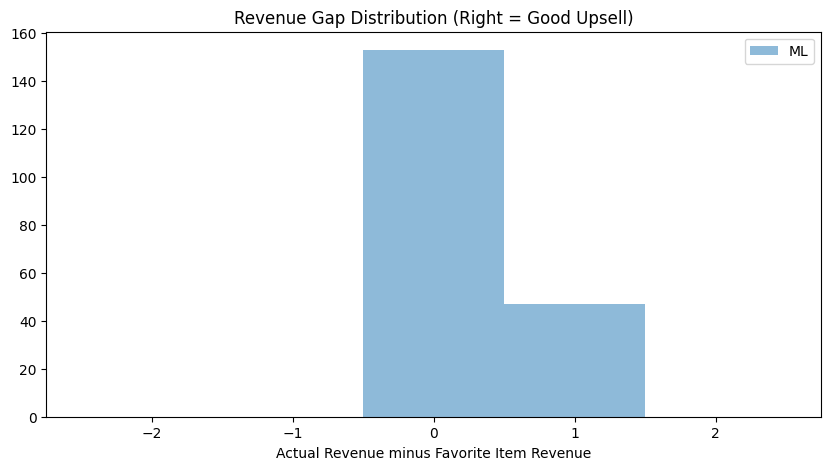

In [15]:
# =============================================================================
# EXTENSION 2: REVENUE GAP ANALYSIS
# =============================================================================
def analyze_revenue_gap(report_df, users_df, restaurants_df):
    gap_data = []

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']
        actual_rev = row['Revenue']

        # Find True Favorite Price
        user = users_df[users_df['user_id'] == u_id].iloc[0]
        best_util = -np.inf
        fav_price = 0

        for _, rest in restaurants_df.iterrows():
            # Use your GT Utility function here
            # (Replace get_gt_utility with get_gt_features_and_utility if needed)
            u = get_gt_utility(user, rest)
            if u > best_util:
                best_util = u
                fav_price = rest['price_level']

        # Calculate Gap: (Actual - Favorite)
        # Positive = You upsold them!
        # Negative = You undersold them (or they settled for less)
        gap_data.append(actual_rev - fav_price)

    return pd.Series(gap_data)

# Calculate Gaps
ml_gaps = analyze_revenue_gap(ml_report_df, users, restaurants)

print(f"ML  Avg Upsell: ${ml_gaps.mean():.2f}")

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(ml_gaps, alpha=0.5, label='ML', bins=[-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
plt.legend()
plt.title("Revenue Gap Distribution (Right = Good Upsell)")
plt.xlabel("Actual Revenue minus Favorite Item Revenue")
plt.show()

In [16]:
# =============================================================================
# EXTENSION 3: PRICE SENSITIVITY MATRIX (ML VERSION)
# =============================================================================

# 1. Merge Tolerance into the ML report
# Note: Check if your ML report uses 'User ID' or 'user_id'
uid_col = 'User ID' if 'User ID' in ml_report_df.columns else 'user_id'

merged_ml = ml_report_df.merge(users[['user_id', 'price_tolerance']], left_on=uid_col, right_on='user_id')

print("--- ML: User Tolerance vs Chosen Price ---")
# 2. Create the Cross-Tabulation
matrix_ml = pd.crosstab(
    merged_ml['price_tolerance'],
    merged_ml['Revenue'],
    rownames=['User Tolerance'],
    colnames=['Chosen Price']
)

display(matrix_ml)

# 3. Calculate "Upsell Rate" (Percentage of users buying ABOVE their tolerance)
# Note: This is rare because penalty is high, but interesting to check.
upsells = merged_ml[merged_ml['Revenue'] > merged_ml['price_tolerance']].shape[0]
print(f"\nTotal users forced to buy ABOVE tolerance: {upsells}")

--- ML: User Tolerance vs Chosen Price ---


Chosen Price,1,2,3
User Tolerance,,,
1,27,48,0
2,0,65,0
3,0,28,32



Total users forced to buy ABOVE tolerance: 48
